# Genetic-Algorithm operators for the **Running-Dinner** problem DEMO

# Table of Contents
- [1. Introduction](#intro)
- [2. Setup & Imports](#setup)
- [3. Running Dinner Problem Configs](#configs)
- [4. Dinner Problem Configs](#configs)
  - [3.1 Other Load](#customload)

--- 

----

# 1. Introduction <a class="anchor" id="intro"></a>

----

This notebook showcases every custom component in the `Genetic_algorithm` folder:
* config.py
* genome.py
* fitness.py
* mutations.py
* crossovers.py
* selection_algorithms.py

### How They Work Together

1. **`Genome`** defines how a candidate solution looks like at the array level.  
2. **`ResourceFitness`** defines how good any given `Genome` is, given the distance matrix and weights ($\alpha$ and $\beta$)
3. A **`SolutionRD`** object wraps `Genome` and `ResourceFitness`, and then offers `.mutation()`, `.crossover()`, and a `.fitness` property to drive the evolutionary loop.
4. While **`config.py`** defines the problem's hard parameters

----

# 2. Setup & Imports <a class="anchor" id="setup"></a>
Import packages & data

----

In [ ]:
import os, sys, random, numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
from pathlib import Path
sys.path.append(os.path.abspath("."))

# Genetic Algorithm 
import Genetic_algorithm.config as config
from Genetic_algorithm.genome import Genome
from Genetic_algorithm.fitness import ResourceFitness
from Genetic_algorithm.mutations import social_mutation, logistic_mutation, logistic_mutation_2
from Genetic_algorithm.crossovers import social_crossover, logistic_crossover_2, full_crossover
from Genetic_algorithm.selection_algorithms import tournament_selection, rank_selection
from Genetic_algorithm.solution_rd import SolutionRD

random.seed(0)
np.random.seed(0)

Now, let's import the **official** travel-time matrix:

```text
data/distance_matrix_official.csv   →   pandas DataFrame   →   NumPy array

In [2]:
# Path to the CSV
csv_path = Path("data/distance_matrix_official.csv")
assert csv_path.exists(), f"CSV not found: {csv_path}"

# Number of participants
n = config.N_PARTICIPANTS

# We assume the CSV has a leading index‐column plus N data columns, and at least N+1 rows total.
usecols = [0] + list(range(1, n+1))  # keep the index-col plus the first n data cols
df = pd.read_csv(
    csv_path,
    index_col=0,
    usecols=usecols,
    nrows=n
)

# Convert to NumPy array
distance_matrix = df.to_numpy()
assert distance_matrix.shape == (n, n), (
    f"Expected ({n},{n}), got {distance_matrix.shape}"
)

print("Loaded distance matrix shape:", distance_matrix.shape)

Loaded distance matrix shape: (10, 10)


----

# 3. Running Dinner Problem Configs <a class="anchor" id="configs"></a>
`config.py` keeps all hard-coded parameters

----

In [3]:
attrs = ["N_PARTICIPANTS", "N_COURSES", "N_HOUSES",
         "HOUSE_CAPACITY", "LEN_COURSE"]
for a in attrs:
    print(f"{a:16} → {getattr(config, a)}")

N_PARTICIPANTS   → 10
N_COURSES        → 3
N_HOUSES         → 7
HOUSE_CAPACITY   → 6
LEN_COURSE       → 12


----

# 4. Fitness & Genome <a class="anchor" id="fitness"></a>
* `genome.py` defines a class that models the genotype of a Running Dinner solution.
* `fitness.py` defines a class that implements the fitness function for a Running Dinner solution.

----

## Class: `Genome`

- **Role & Responsibility:**  
  - Holds two core arrays:  
    1. **`house_assignments`** (`int[N_HOUSES]`): which course each house hosts (or `-1` if unused).  
    2. **`course_assignments`** (`int[N_COURSES × LEN_COURSE]`): which participants sit at each “seat” in each course.  
  - Provides methods to **encode** these arrays into a 1-D chromosome, **decode** back, and query slices (e.g. “which seats belong to course _𝑐_”).  
  - Encapsulates all low-level bit twiddling needed to shuffle, swap, or extract subblocks when applying genetic operators.  

- **Instances of `Genome`:**  
  - Are concrete **genotypes** (i.e. a specific assignment of hosts & guests).  
  - Get passed into `SolutionRD` objects and get mutated, crossed over, and ultimately evaluated.

## Class: `ResourceFitness`

- **Role & Responsibility:**  
  - Stores the **distance matrix** (participant-to-participant travel times) plus two weights, **α** (social) and **β** (logistic).  
  - Defines an `.evaluate(genome: Genome) → float` method that:  
    1. Computes a **social score**: number of unique meetings/N_PARTICIPANTS. We want to maximize the average number of unique people met per participant.  
    2. Computes a **logistic score**: max distance/actual distance. We want to maximize the logistic score by minimizing the actual distance traveled by participants.  
    3. Combines them as:  
       $
         \text{fitness} = \alpha \times s_s \;+\; \beta \times s_l
       $

- **Instances of `ResourceFitness`:**  
  - Are passed to each `SolutionRD` so that an individual can lazily compute and cache its `.fitness` by calling into this evaluator.

---

`SolutionRD` wraps a `Genome`, the fitness instance and the operator lists.  
It evaluates lazily: `individual.fitness` triggers `ResourceFitness.evaluate`.

Let's create an instance of SolutionRD:

In [4]:
fitness = ResourceFitness(distance_matrix, alpha=1.0, beta=1.0)

ind = SolutionRD(
    fitness_instance = fitness,
    genome_class     = Genome,
    mutation_functions   = [social_mutation, logistic_mutation],
    crossover_functions  = [social_crossover, logistic_crossover_2],
)
# Access the individual's fitness (lazy evaluation is triggered by the property)
print("Encoded genome sample:\n", ind.genome.encode())
print("Decoded genome sample:\n", ind.genome.decode())
print("Individual's house assignments:\n", ind.genome.house_assignments)
print("Individual's course assignments:\n", ind.genome.course_assignments)
print("Individual's fitness:", ind.fitness)

Encoded genome sample:
 [-1  1  0  1  0  2  2  7 -1  1  2  9  8  0  6  7  4 -1  7  1 -1  9  0  3
  2  4  8 -1  3  5  6  5  8  3  4 -1 -1  5  9  6  2  0  1]
Decoded genome sample:
 (array([-1,  1,  0,  1,  0,  2,  2]), array([ 7, -1,  1,  2,  9,  8,  0,  6,  7,  4, -1,  7,  1, -1,  9,  0,  3,
        2,  4,  8, -1,  3,  5,  6,  5,  8,  3,  4, -1, -1,  5,  9,  6,  2,
        0,  1]))
Individual's house assignments:
 [-1  1  0  1  0  2  2]
Individual's course assignments:
 [ 7 -1  1  2  9  8  0  6  7  4 -1  7  1 -1  9  0  3  2  4  8 -1  3  5  6
  5  8  3  4 -1 -1  5  9  6  2  0  1]
Individual's fitness: 2.9078909793070795


In [5]:
# 1) Your encoded array:
encoded = np.array([
    -1,  1,  0,  1,  0,  2,  2,
     3, -1,  1, -1,  9,  8,  0,  6,  7,  4,  2,  5,  1, -1,  9,  0,  3,
     2,  4,  8, -1,  7,  5,  6,  7,  8,  3,  4, -1, -1,  5,  9,  6,  2,  0,  1
])

# 2) Split into house & course arrays
n_houses = config.N_HOUSES
houses = encoded[:n_houses]
courses = encoded[n_houses:]

# 3) Create a dummy Genome and override
gen = Genome.__new__(Genome)
gen._house_assignments  = houses.copy()
gen._course_assignments = courses.copy()

# 4) Secure owners into their blocks (in-place)
gen.secure_all_owner_to_houses()

# 5) Validate: each hosting house has its owner seated
for h in range(n_houses):
    course = gen.house_assignments[h]
    if course == -1:
        continue  # unused house
    start, end = gen.get_house_position(h)
    block = gen.course_assignments[start:end]
    assert h in block, (
        f"❌ Owner {h} missing from house {h}'s course block "
        f"(course {course} seats {start}:{end})"
    )

print("✅ All hosts are correctly seated in their own course blocks!")


✅ All hosts are correctly seated in their own course blocks!


SolutionRD's genome is composed of two blocks: house_assignments and course_assignments.

* **house assignments**: An array of length N_HOUSES in which the entry at index i denotes the course (0=starter, 1=main, 2=dessert, or –1 for an unused house) served at house i. 

    In the example above:
        * house with index 0 will not host any meals
        * house with index 1 will host main course
        * house with index 2 will host appetizer
        * house with index 3 will host main course
        * house with index 4 will host appetizer
        * house with index 5 will host dessert
        * house with index 6 will host dessert


* **course assignments**: An array of length N_COURSES × LEN_COURSE, i.e., N_COURSES consecutive blocks each of size LEN_COURSE. Each entry in that block is a participant index (0 to N_PARTICIPANTS–1), or -1 if that “seat” in the course is unused.

    In the example above:
        * the first 12 integers decode participants of the house hosting dessert one and two:
        

In [6]:
print("Loaded distance matrix shape:", distance_matrix.shape)
print("Distance matrix:\n", pd.DataFrame(distance_matrix))
# Set the display format for floats
# Display float with 1 decimal place
pd.options.display.float_format = '{:0.1f}'.format

Loaded distance matrix shape: (10, 10)
Distance matrix:
        0      1       2       3       4       5       6       7       8  \
0  0.001  9.700  50.900  22.800  15.800  56.200  54.000   7.800  18.100   
1    NaN  0.001  43.900  15.800  10.500  49.200  47.100   3.500  11.000   
2    NaN    NaN   0.001  13.900  17.000   5.300   3.100  19.900   7.600   
3    NaN    NaN     NaN   0.001  45.000  33.300  31.200  47.900  35.600   
4    NaN    NaN     NaN     NaN   0.001  51.500  49.400  14.800  16.500   
5    NaN    NaN     NaN     NaN     NaN   0.001  44.400  14.600  11.500   
6    NaN    NaN     NaN     NaN     NaN     NaN   0.001  16.800   4.400   
7    NaN    NaN     NaN     NaN     NaN     NaN     NaN   0.001  13.100   
8    NaN    NaN     NaN     NaN     NaN     NaN     NaN     NaN   0.001   
9    NaN    NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

        9  
0  18.300  
1   7.900  
2  10.500  
3  38.600  
4  18.800  
5  13.800  
6   7.400  
7  10.200  
8   6.300

The distance matrix above represents the distances between running dinner participants and their homes (if they are hosts). It is used in `ResourceFitness` to calculate logistic score.

## Mutation Demonstrations

Below we show each mutation in isolation. We start from the same seed-fixed individual, then apply each operator to see “before → after.”

---

#### 1. Logistic Mutation 2 (pacman mutation)

Explain this mutation here

In [7]:
np.random.seed(0)
# build demo individual 
fitness  = ResourceFitness(distance_matrix, alpha=1.0, beta=1.0)
base_ind = SolutionRD(fitness, Genome,
                      mutation_functions=[logistic_mutation_2, logistic_mutation_2],
                      crossover_functions=[])

# deep copy the base individual
mutant1 = copy.deepcopy(base_ind)

In [8]:
# apply logistic_mutation_2
mutant1.mutation()

# display base_ind genome
print("Base individual genome:\n", base_ind.genome.encode())
print("Mutant individual genome:\n", mutant1.genome.encode())

print("Base individual house assignments:\n", base_ind.genome.house_assignments)
print("Mutant individual house assignments:\n", mutant1.genome.house_assignments)
 
print("Base individual course assignments:\n", base_ind.genome.course_assignments) 
print("Mutant individual course assignments:\n", mutant1.genome.course_assignments)

print("Base individual fitness:", base_ind.fitness)
print("Mutant individual fitness:", mutant1.fitness)

Base individual genome:
 [-1  1  0  1  0  2  2 -1 -1  1  2  9  8  0  6  7  4 -1  4  1 -1  9  0  3
  2  4  8  3  7  5  6  7  8  3  5 -1 -1  5  9  6  2  0  1]
Mutant individual genome:
 [ 1  0  1  0  2  2 -1 -1 -1  1  5  9  8  0  3  7  3 -1  4  1 -1  9  0  6
  2  4  8  3  7  2  6  7  8  4  5 -1 -1  5  9  6  2  0  1]
Base individual house assignments:
 [-1  1  0  1  0  2  2]
Mutant individual house assignments:
 [ 1  0  1  0  2  2 -1]
Base individual course assignments:
 [-1 -1  1  2  9  8  0  6  7  4 -1  4  1 -1  9  0  3  2  4  8  3  7  5  6
  7  8  3  5 -1 -1  5  9  6  2  0  1]
Mutant individual course assignments:
 [-1 -1  1  5  9  8  0  3  7  3 -1  4  1 -1  9  0  6  2  4  8  3  7  2  6
  7  8  4  5 -1 -1  5  9  6  2  0  1]
Base individual fitness: 2.7981426768299995
Mutant individual fitness: 3.022133802018967


#### 2. Logistic Mutation 

Explain this mutation here

In [9]:
# build demo individual 
fitness  = ResourceFitness(distance_matrix, alpha=1.0, beta=1.0)
base_ind = SolutionRD(fitness, Genome,
                      mutation_functions=[logistic_mutation, logistic_mutation],
                      crossover_functions=[])

# deep copy the base individual
mutant2 = copy.deepcopy(base_ind)

In [10]:
# apply logistic_mutation
mutant2.mutation()

# display base_ind genome
print("Base individual genome:\n", base_ind.genome.encode())
print("Mutant individual genome:\n", mutant2.genome.encode())

print("Base individual house assignments:\n", base_ind.genome.house_assignments)
print("Mutant individual house assignments:\n", mutant2.genome.house_assignments)

print("Base individual course assignments:\n", base_ind.genome.course_assignments)
print("Mutant individual course assignments:\n", mutant2.genome.course_assignments)

print("Base individual fitness:", base_ind.fitness)
print("Mutant individual fitness:", mutant2.fitness)

Base individual genome:
 [ 2  1 -1  2  0  0  1 -1  9  4 -1  2  8  6  1  7 -1  5 -1  1  5  3  9  4
 -1  6  7  8  2  0  1 -1  0  4  3  9  6  7  2  5  8  3  0]
Mutant individual genome:
 [ 2  1 -1  2  0  0  1 -1  9  4 -1  2  8  6  1  7 -1  5 -1  1  5  3  9  4
 -1  6  7  8  2  0  1 -1  0  4  3  9  6  7  2  5  8  3  0]
Base individual house assignments:
 [ 2  1 -1  2  0  0  1]
Mutant individual house assignments:
 [ 2  1 -1  2  0  0  1]
Base individual course assignments:
 [-1  9  4 -1  2  8  6  1  7 -1  5 -1  1  5  3  9  4 -1  6  7  8  2  0  1
 -1  0  4  3  9  6  7  2  5  8  3  0]
Mutant individual course assignments:
 [-1  9  4 -1  2  8  6  1  7 -1  5 -1  1  5  3  9  4 -1  6  7  8  2  0  1
 -1  0  4  3  9  6  7  2  5  8  3  0]
Base individual fitness: 2.71510534548266
Mutant individual fitness: 2.71510534548266


#### 3. Social Mutation 

Explain this mutation here

In [11]:
# build demo individual 
fitness  = ResourceFitness(distance_matrix, alpha=1.0, beta=1.0)
base_ind = SolutionRD(fitness, Genome,
                      mutation_functions=[social_mutation, social_mutation],
                      crossover_functions=[])

# deep copy the base individual
mutant3 = copy.deepcopy(base_ind)

In [12]:
# apply social_mutation
mutant3.mutation()

# display base_ind genome
print("Base individual genome:\n", base_ind.genome.encode())
print("Mutant individual genome:\n", mutant3.genome.encode())

print("Base individual house assignments:\n", base_ind.genome.house_assignments)
print("Mutant individual house assignments:\n", mutant3.genome.house_assignments)

print("Base individual course assignments:\n", base_ind.genome.course_assignments)
print("Mutant individual course assignments:\n", mutant3.genome.course_assignments)

print("Base individual fitness:", base_ind.fitness)
print("Mutant individual fitness:", mutant3.fitness)

Base individual genome:
 [ 1  2  2  0 -1  0  1  1  2  6 -1  8  3  7  9  5 -1  4 -1  5  0  7  4 -1
  2  1  6  3  9  0  8  8  9  6  1  4  0  3 -1  7 -1  5  2]
Mutant individual genome:
 [ 1  2  2  0 -1  0  1  1  2  6 -1  8  3  7  9  5 -1  4 -1  5  0  7  4 -1
  2  1  6  3  9  0  8  8  9  6  1  4  0  3 -1  7 -1  5  2]
Base individual house assignments:
 [ 1  2  2  0 -1  0  1]
Mutant individual house assignments:
 [ 1  2  2  0 -1  0  1]
Base individual course assignments:
 [ 1  2  6 -1  8  3  7  9  5 -1  4 -1  5  0  7  4 -1  2  1  6  3  9  0  8
  8  9  6  1  4  0  3 -1  7 -1  5  2]
Mutant individual course assignments:
 [ 1  2  6 -1  8  3  7  9  5 -1  4 -1  5  0  7  4 -1  2  1  6  3  9  0  8
  8  9  6  1  4  0  3 -1  7 -1  5  2]
Base individual fitness: 2.7872079040376283
Mutant individual fitness: 2.7872079040376283


## Crossover Demonstrations

Below we show each crossover in isolation. We start from the same seed-fixed individual, then apply each operator to see “before → after.”

---

#### 1. Full Crossover 

Explain this mutation here

In [13]:
np.random.seed(0)
# build demo individual 
fitness  = ResourceFitness(distance_matrix, alpha=1.0, beta=1.0)
parent1 = SolutionRD(fitness, Genome, [], [full_crossover, full_crossover])
parent2 = SolutionRD(fitness, Genome, [], [full_crossover, full_crossover])

print("Parent1 house assignments:\n", parent1.genome.house_assignments)
print("Parent2 house assignments:\n", parent2.genome.house_assignments)
print("Parent1 course assignments:\n", parent1.genome.course_assignments)
print("Parent2 course assignments:\n", parent2.genome.course_assignments)
print("Parent1 fitness:", parent1.fitness)
print("Parent2 fitness:", parent2.fitness)

Parent1 house assignments:
 [-1  1  0  1  0  2  2]
Parent2 house assignments:
 [ 2  1 -1  2  0  0  1]
Parent1 course assignments:
 [ 7 -1  1  2  9  8  0  6  7  4 -1  5  1 -1  9  0  3  2  4  8 -1  7  3  6
  5  8  3  4 -1 -1  5  9  6  2  0  1]
Parent2 course assignments:
 [ 9  9 -1  5  4  8  6  5  7  2 -1  4 -1  5  3  1  4 -1  6  7  8  2  0  1
 -1 -1  0  3  9  6  7  2  3  8  1  0]
Parent1 fitness: 3.2957501549978985
Parent2 fitness: 2.852621358641419


In [14]:
# apply crossover
child1, child2 = parent1.crossover(parent2)

# Display the child1 and child2 genomes after full crossover
print("Child1 house assignments:\n", child1.genome.house_assignments)
print("Child2 house assignments:\n", child2.genome.house_assignments)
print("Child1 course assignments:\n", child1.genome.course_assignments)
print("Child2 course assignments:\n", child2.genome.course_assignments)
print("Child1 fitness:", child1.fitness)
print("Child2 fitness:", child2.fitness)

Child1 house assignments:
 [ 2  1 -1  2  0  0  1]
Child2 house assignments:
 [-1  1  0  1  0  2  2]
Child1 course assignments:
 [ 7 -1  1  4  9  8  8  6  7  2 -1  5  1 -1  9  0  0  2  4  8 -1  7  3  6
  5  0  3  4 -1 -1  5  9  6  2  3  1]
Child2 course assignments:
 [ 9  9 -1  2  4  8  7  0  7  5 -1  4 -1  5  0  1  4 -1  6  7  8  2  3  1
 -1 -1  5  3  9  6  6  2  3  8  1  0]
Child1 fitness: 3.2529624817329883
Child2 fitness: 2.999040622345039


#### 2. Social Crossover 

Explain this mutation here

In [15]:
np.random.seed(0)
# build demo individual 
fitness  = ResourceFitness(distance_matrix, alpha=1.0, beta=1.0)
parent1 = SolutionRD(fitness, Genome, [], [social_crossover, social_crossover])
parent2 = SolutionRD(fitness, Genome, [], [social_crossover, social_crossover])

print("Parent1 house assignments:\n", parent1.genome.house_assignments)
print("Parent2 house assignments:\n", parent2.genome.house_assignments)
print("Parent1 course assignments:\n", parent1.genome.course_assignments)
print("Parent2 course assignments:\n", parent2.genome.course_assignments)
print("Parent1 fitness:", parent1.fitness)
print("Parent2 fitness:", parent2.fitness)

Parent1 house assignments:
 [-1  1  0  1  0  2  2]
Parent2 house assignments:
 [ 2  1 -1  2  0  0  1]
Parent1 course assignments:
 [ 4 -1  1 -1  2  8  0  6  7  4  9  7  1 -1  9  0  3  2  3  8 -1  7  5  6
  5  8  3  4 -1 -1  5  9  6  2  0  1]
Parent2 course assignments:
 [ 9  9 -1  6  2  4  6  0  7  8 -1  5 -1  5  3  1  4 -1  6  7  8  2  0  1
 -1 -1  4  3  9  0  7  2  5  8  1  3]
Parent1 fitness: 3.119017642221821
Parent2 fitness: 3.0445594231530757


In [16]:
# apply social crossover
child3, child4 = parent1.crossover(parent2)

# display child3 and child4 genome after social crossover
print("Child3 house assignments:\n", child3.genome.house_assignments)
print("Child4 house assignments:\n", child4.genome.house_assignments)
print("Child3 course assignments:\n", child3.genome.course_assignments)
print("Child4 course assignments:\n", child4.genome.course_assignments)
print("Child3 fitness:", child3.fitness)
print("Child4 fitness:", child4.fitness)

Child3 house assignments:
 [-1  1  0  1  0  2  2]
Child4 house assignments:
 [ 2  1 -1  2  0  0  1]
Child3 course assignments:
 [ 4  6  9  7  2  1 -1  8  7  0 -1  4  9  6  3  5  7 -1  1 -1  2  8  0  3
  6  8 -1  2  5  4  0  3  1 -1  9  5]
Child4 course assignments:
 [ 8  9 -1  9  2  6  0 -1  7  6  5  4  1  2  7  6  1  0  8  4  3  5 -1 -1
 -1  0  2  5 -1  9  8  7  3  1  3  4]
Child3 fitness: 3.0195023831501326
Child4 fitness: 2.7318475471739627


#### 3. Logistic Crossover 

Explain this mutation here

In [17]:
np.random.seed(0)
# build demo individual 
fitness  = ResourceFitness(distance_matrix, alpha=1.0, beta=1.0)
parent1 = SolutionRD(fitness, Genome, [], [logistic_crossover_2, logistic_crossover_2])
parent2 = SolutionRD(fitness, Genome, [], [logistic_crossover_2, logistic_crossover_2])

print("Parent1 house assignments:\n", parent1.genome.house_assignments)
print("Parent2 house assignments:\n", parent2.genome.house_assignments)
print("Parent1 course assignments:\n", parent1.genome.course_assignments)
print("Parent2 course assignments:\n", parent2.genome.course_assignments)
print("Parent1 fitness:", parent1.fitness)
print("Parent2 fitness:", parent2.fitness)

Parent1 house assignments:
 [-1  1  0  1  0  2  2]
Parent2 house assignments:
 [ 2  1 -1  2  0  0  1]
Parent1 course assignments:
 [-1 -1  1  2  9  8  0  6  7  4 -1  8  1 -1  9  0  3  2  4  8  3  7  5  6
  7  5  3  4 -1 -1  5  9  6  2  0  1]
Parent2 course assignments:
 [ 4  9 -1  3  2  8  6  5  7  0 -1  6 -1  5  1  9  4 -1  6  7  8  2  0  1
 -1 -1  4  3  9  0  7  2  5  8  1  3]
Parent1 fitness: 2.9981426768299992
Parent2 fitness: 3.2312430479644165


In [18]:
# Apply logistcic crossover
child5, child6 = parent1.crossover(parent2)

# display child5 and child 6 genomes after logistic crossover
print("Child5 house assignments:\n", child5.genome.house_assignments)
print("Child6 house assignments:\n", child6.genome.house_assignments)
print("Child5 course assignments:\n", child5.genome.course_assignments)
print("Child6 course assignments:\n", child6.genome.course_assignments)
print("Child5 fitness:", child5.fitness)
print("Child6 fitness:", child6.fitness)

Child5 house assignments:
 [ 2  1  0  1  0 -1  2]
Child6 house assignments:
 [ 0  1  2  2  0 -1  1]
Child5 course assignments:
 [-1 -1  1  2  9  8  5  6  7  4 -1  8  1 -1  9  0  3  2  4  8  3  7  5  6
  7  0  3  4 -1 -1  5  9  6  2  0  1]
Child6 course assignments:
 [-1  0 -1  3 -1  8  6  5  7  9  4  6 -1  5  1  9  4 -1  6  7  8  2  0  1
 -1  2  4  3  9  0  7  2  5  8  1  3]
Child5 fitness: 3.0114101281250703
Child6 fitness: 2.957128608531607


## Selection Demonstration (Maximization)

We create a population of 10 `SolutionRD` individuals (with random distance matrix) and then pick the **highest-fitness** survivors using:

- **Tournament Selection** (k‐way): randomly sample \(k\) individuals and choose the one with the best fitness.  
- **Rank Selection**: sort individuals by fitness (highest→lowest), assign selection probabilities proportionally to rank, and draw one.

Both return the `SolutionRD` instance with the **maximum** `.fitness` value.

In [19]:
random.seed(0)
# Generate a population of 10 individuals
pop = [
    SolutionRD(
        fitness_instance   = fitness,
        genome_class       = Genome,
        mutation_functions = [social_mutation, logistic_mutation],
        crossover_functions= [social_crossover, logistic_crossover_2]
    )
    for _ in range(10)
]

# Tournament selection (k=3), picks the individual with highest fitness among 3 random draws
winner_tournament = tournament_selection(pop, k=3)

# Rank selection, assigns probabilities by descending fitness rank and selects one
winner_rank  = rank_selection(pop)

# 5) report
print("Starting population fitnesses:")
for i, ind in enumerate(pop):
    print(f"  {i:2}: {ind.fitness:.2f}")
print("Tournament winner fitness:", winner_tournament.fitness)
print("Rank-selection winner fitness:", winner_rank.fitness)

Starting population fitnesses:
   0: 3.28
   1: 2.56
   2: 2.98
   3: 2.31
   4: 2.27
   5: 2.60
   6: 2.69
   7: 2.83
   8: 2.64
   9: 2.20
Tournament winner fitness: 2.5577170503731046
Rank-selection winner fitness: 2.6943420338231467


## Experiment: Selection Pressure vs. Average Winner Fitness

We will run 100 independent trials and plot:

**Tournament Selection**: influence of tournament size `k` (with fixed population size).  



In [20]:
data_matrix_df = pd.read_csv('data/distance_matrix_official.csv', index_col=0)
data_matrix_np = data_matrix_df.to_numpy()

# a helper function to generate population of different sizes
def gen_pop(pop_size, genome_class, fitness_instance, mutation_functions, crossover_functions):
    return [
        SolutionRD(
            fitness_instance   = fitness_instance,
            genome_class       = genome_class,
            mutation_functions = mutation_functions,
            crossover_functions= crossover_functions
        )
        for _ in range(pop_size)
    ]

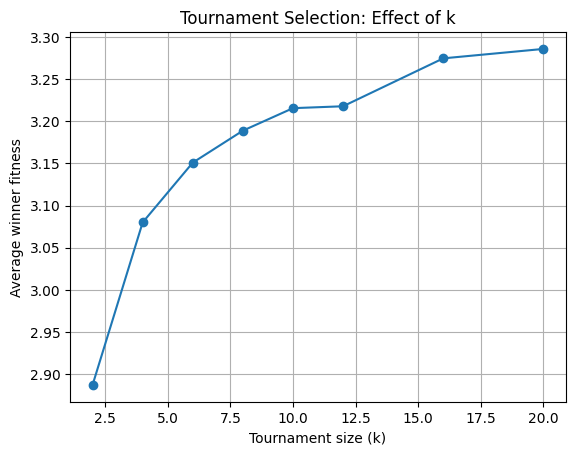

In [21]:
# 1) Tournament-selection: vary k, fix pop_size
pop_size = 20
k_values = [2, 4, 6, 8, 10, 12, 16, 20]
avg_fitness_tourn = []
for k in k_values:
    favgs = []
    for _ in range(100):
        pop = gen_pop(pop_size, Genome, fitness, [social_mutation, logistic_mutation], [social_crossover, logistic_crossover_2])
        winner = tournament_selection(pop, k=k)
        favgs.append(winner.fitness)
    avg_fitness_tourn.append(np.mean(favgs))

# Plot tournament results
plt.figure()
plt.plot(k_values, avg_fitness_tourn, marker='o')
plt.xlabel("Tournament size (k)")
plt.ylabel("Average winner fitness")
plt.title("Tournament Selection: Effect of k")
plt.grid(True)
plt.show()

In the next notebooks we will:

* wrap the above in an evolutionary loop,
* grid-search parameters (see *Grid_search.ipynb*).